# S&P500 Price Movement Prediction
In this notebook, we will build a long short term memory (LSTM) model to predict whether the price of the S&P500 will increase or not tomorrow.

#### Import Libraries and Dataset

In [57]:
import yfinance as yf
import pandas_ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
import keras_tuner
import warnings
warnings.filterwarnings('ignore')


In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
# Looks back at S&P500 price data from the very start

sp500 = sp500.history(period='max')

In [4]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


<Axes: xlabel='Date'>

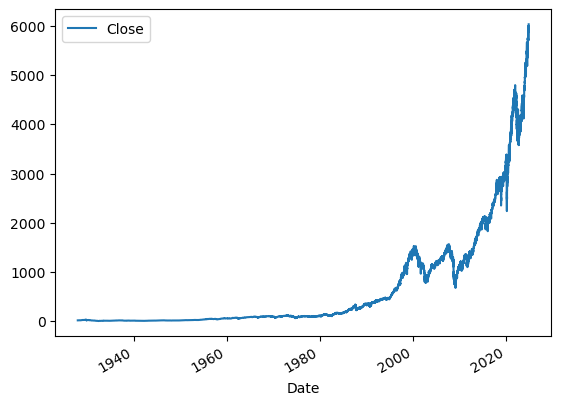

In [5]:
sp500.plot.line(y='Close', use_index=True)

In [6]:
# Dropping unnecessary columns

sp500.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

### Price Movement Prediction

Target: Whether the price will increase or decrease tomorrow. On days where the price goes up, can we predict whether the price will go up?

To create this "Target", we will first create a column called "Tomorrow" which is the close price of the next market day.

In [7]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [8]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000


Creating "Target" where 1: Price increased the next market day and 0: Price did not increase the next market day.

Once we have created "Target", we can drop the "Tomorrow" column. 

In [9]:
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
sp500.drop(columns=['Tomorrow'], inplace=True)

In [10]:
sp500.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0


We are going to remove all data before 1990 because the stock market before this time was very different from what it is now. Because we are using historical data to make predictions, it is important we take this into consideration. Over the years, the stock market saw more multinational companies and as technology and economies advanced, the stock investing became more popular and there were significantly higher trading volumes.

In [11]:
sp500 = sp500.loc['1990-01-01':].copy()

In [12]:
sp500.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,0


In [13]:
sp500.isnull().sum().max()

0

Let's remove the last row as the price data for the latest following day is not generated yet.

In [14]:
sp500.drop(sp500.tail(1).index, inplace=True)

In [15]:
sp500

,Open,High,Low,Close,Volume,Target
Date,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,0
...,...,...,...,...,...,...
2024-11-21 00:00:00-05:00,5940.580078,5963.319824,5887.259766,5948.709961,4230120000,1
2024-11-22 00:00:00-05:00,5944.359863,5972.899902,5944.359863,5969.339844,4141420000,1
2024-11-25 00:00:00-05:00,5992.279785,6020.750000,5963.910156,5987.370117,5633150000,1


### ML Model Training

We are going to train a baseline ML model using random forest. Random forest is a good baseline model because it works by training an ensemble of decision trees with randomised parameters and aggregates the results from these decision trees. Therefore, it is more difficult for random forests to overfit. Furthermore, they can spot non-linear relationships in our dataset.

We are not going to use cross validation because our dataset is a time series. Cross validation will not take into account the datetime. Therefore, we might be using future data to predict past datapoints. This is data leakage. 

In [16]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [17]:
# We are predicting whether the price went up

predictions = model.predict(test[predictors])
predictions = pd.Series(predictions, index=test.index)

In [18]:
precision_score(test['Target'], predictions)

0.5757575757575758

Our baseline model gave a precision score of ~0.58. This means that out of all the times we said the price would increase, it actually only increased 58% of the time.

Let's plot the combined targets of our predictions and the actual targets.

<Axes: xlabel='Date'>

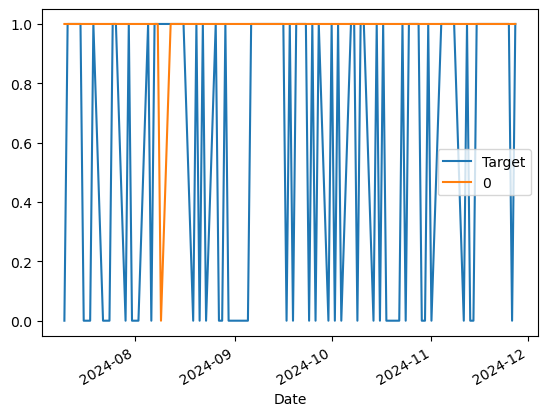

In [19]:
combined = pd.concat([test['Target'], predictions], axis=1)
combined.plot()

The baseline model predicted the price to increase almost everyday.

### Building a Backtesting System

We need to build a more robust method to test our model. Our baseline model could only use the last 100 days to test its performance. However, we need to test across multiple years of data to be able to be used in the real world.

Therefore, we are going to create a backtesting system.

In [20]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    predictions = model.predict(test[predictors])
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], predictions], axis=1)
    return combined

The backtesting model works like this:
- Each trading year has about 250 trading days
- The model is first trained on the first 10 years of data to predict the targets of the 11th year in the data
- The model is then trained on the first 11 years of data to predict the targets of the 12th year in the data and so on

In [21]:
import statistics

def backtest(data, model, predictors, start=2500, step=250):
    '''
        Backtest the model on the data.
        Every trading year has approximately 250 trading days.
        Take 10 years of data, train the first model with 10 years of data to predict the target values of the 11th year.
        Next step would be training the model with 11 years of data to predict the target values of the 12th year. 

        Parameters:
            data: S&P500 dataframe
            model: Machine learning model
            predictors: List of columns to use as predictors
            start: Start index of the data to use for training and predicting. Default is 2500, which is about 10 years.
            step: Step size for training and predicting. Default is 250, which is about 1 year.

        Returns:
            DataFrame: Contains the target values and predictions
    '''
    # List of dataframes where each dataframe is the prediction of a single year
    all_predictions = []
    precision_scores = []
    accuracy_scores = []
    f1_scores = []

    # Iterate over the data, taking one more year to train the model, starting with 10 years and predicting the target values of the next year.
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions = predict(train, test, predictors, model)
        precision = precision_score(predictions['Target'], predictions['Predictions'])
        precision_scores.append(precision)
        accuracy = accuracy_score(predictions['Target'], predictions['Predictions'])
        accuracy_scores.append(accuracy)
        f1 = f1_score(predictions['Target'], predictions['Predictions'])
        f1_scores.append(f1)
        all_predictions.append(predictions)
    print(f'Average Precision Score of {model}:', statistics.mean(precision_scores))
    print(f'Average Accuracy Score of {model}:', statistics.mean(accuracy_scores))
    print(f'Average f1 Score of {model}:', statistics.mean(f1_scores))
    return pd.concat(all_predictions)

In [22]:
predictions = backtest(sp500, model, predictors)

Average Precision Score of RandomForestClassifier(min_samples_split=100, random_state=42): 0.5169336986210012
Average Accuracy Score of RandomForestClassifier(min_samples_split=100, random_state=42): 0.48996581196581196
Average f1 Score of RandomForestClassifier(min_samples_split=100, random_state=42): 0.4095424879582522


In [23]:
predictions['Predictions'].value_counts()

Predictions
0    3572
1    2723
Name: count, dtype: int64

In [24]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5295629820051414

The precision score of our baseline random forest model was ~0.53. Overall, it performed fairly poorly. Let's try to add more features to the dataset to provide our eventual model with more data to make better predictions.

### Adding More Predictor Features

#### Technical Indicators
- Garman-Klass Volatility: Volatility index that consists of using the returns of the open, high, low and closing prices in its calculation.
- RSI: The relative strength index (RSI) measures the speed and magnitude of a stock's price changes to help identify overbought or oversold conditions.
- Bollinger Bands: Helps gauge volatility of stocks and identify over or undervalued prices.
- ATR: Average true range is the average of true ranges over a specified period and measures volatility.
- MACD: The moving average convergence/divergence indicator helps investors identify price trends, measure trend momentum and identify entry points for buying or selling. It shows the relationship between two exponential moving averages (EMAs) of a stock's price.

In [25]:
sp500['Garman_Klass_Volatility'] = ((np.log(sp500['High'])-np.log(sp500['Low']))**2)/2-(2*np.log(2)-1)*((np.log(sp500['Close'])-np.log(sp500['Open']))**2)

In [26]:
sp500['RSI'] = pandas_ta.rsi(close=sp500['Close'], length=14)

In [27]:
sp500['BB_low'] = pandas_ta.bbands(close=sp500['Close'], length=20).iloc[:,0]
sp500['BB_mid'] = pandas_ta.bbands(close=sp500['Close'], length=20).iloc[:,1]
sp500['BB_high'] = pandas_ta.bbands(close=sp500['Close'], length=20).iloc[:,2]

In [28]:
sp500

,Open,High,Low,Close,Volume,Target,Garman_Klass_Volatility,RSI,BB_low,BB_mid,BB_high
Date,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,0,0.000115,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,0,0.000026,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,0,0.000107,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,1,0.000038,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,0,0.000047,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-21 00:00:00-05:00,5940.580078,5963.319824,5887.259766,5948.709961,4230120000,1,0.000082,59.579076,5689.257973,5878.627002,6067.996031
2024-11-22 00:00:00-05:00,5944.359863,5972.899902,5944.359863,5969.339844,4141420000,1,0.000005,61.491255,5696.287802,5886.687988,6077.088174
2024-11-25 00:00:00-05:00,5992.279785,6020.750000,5963.910156,5987.370117,5633150000,1,0.000045,63.132801,5701.973516,5894.880493,6087.787471


#### Horizons

As a trader or investor, I want to see how the price has changed over the past week or past month for example. These time frames are called horizons. 

We are going to use this horizons to create a new feature called 'Close Ratio', which is the ratio between the close price and the rolling average close price within that horizon time frame. 

We are also going to create 'Trend'. The trend is the sum of the targets of horizon on any given day. In other words, for example, for the 5 day horizon, it shows the number of days the stock price actually went up within those 5 days before that given day.

In [29]:
horizons = [2, 5, 60, 250, 1000]

for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    sp500[ratio_column] = sp500['Close'] / rolling_avg['Close']

    trend_column = f'Trend_{horizon}'
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

In [30]:
sp500

,Open,High,Low,Close,Volume,Target,Garman_Klass_Volatility,RSI,BB_low,BB_mid,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,0,0.000115,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,0,0.000026,NaN,NaN,NaN,...,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,0,0.000107,NaN,NaN,NaN,...,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,1,0.000038,NaN,NaN,NaN,...,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,0,0.000047,NaN,NaN,NaN,...,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-21 00:00:00-05:00,5940.580078,5963.319824,5887.259766,5948.709961,4230120000,1,0.000082,59.579076,5689.257973,5878.627002,...,1.002663,2.0,1.006651,4.0,1.033128,35.0,1.123584,146.0,1.332040,529.0
2024-11-22 00:00:00-05:00,5944.359863,5972.899902,5944.359863,5969.339844,4141420000,1,0.000005,61.491255,5696.287802,5886.687988,...,1.001731,2.0,1.006778,5.0,1.035579,36.0,1.126273,147.0,1.335971,529.0
2024-11-25 00:00:00-05:00,5992.279785,6020.750000,5963.910156,5987.370117,5633150000,1,0.000045,63.132801,5701.973516,5894.880493,...,1.001508,2.0,1.006636,5.0,1.037690,36.0,1.128455,147.0,1.339311,530.0


Drop rows with null values

In [31]:
sp500.isnull().sum()

Open                          0
High                          0
Low                           0
Close                         0
Volume                        0
Target                        0
Garman_Klass_Volatility       0
RSI                          14
BB_low                       19
BB_mid                       19
BB_high                      19
Close_Ratio_2                 1
Trend_2                       2
Close_Ratio_5                 4
Trend_5                       5
Close_Ratio_60               59
Trend_60                     60
Close_Ratio_250             249
Trend_250                   250
Close_Ratio_1000            999
Trend_1000                 1000
dtype: int64

In [32]:
sp500 = sp500.dropna().copy()

In [33]:
sp500.isnull().sum().max()

0

In [34]:
sp500_date = sp500.reset_index().copy()
sp500_date.rename(columns={'index': 'Date'}, inplace=True)
sp500_date.head()

,Date,Open,High,Low,Close,Volume,Target,Garman_Klass_Volatility,RSI,BB_low,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
0,1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,0,0.000018,48.121192,459.613590,...,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1,1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,1,0.000005,45.196420,459.553929,...,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
2,1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,1,0.000007,49.278342,459.533488,...,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
3,1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,0,0.000005,56.370864,459.448425,...,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
4,1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,0,0.000004,54.928775,459.505932,...,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


### RSI Plot 

In [35]:
rsi_plot = sp500_date[['Date', 'RSI']]

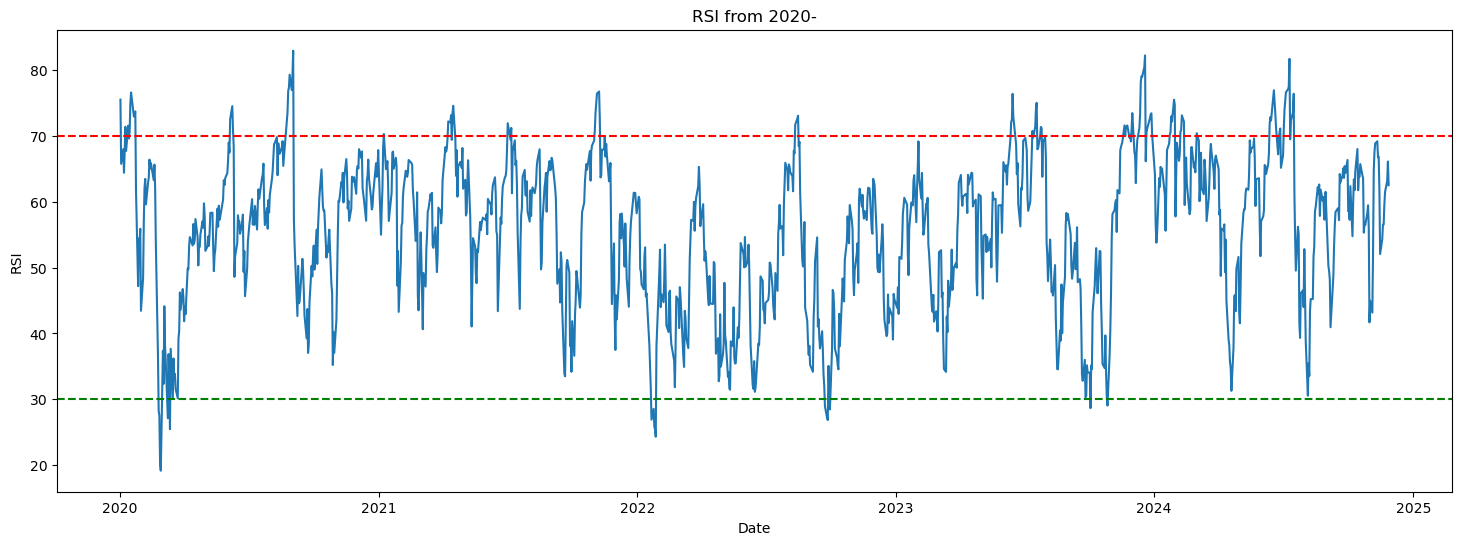

In [36]:
sp500_date['Date'] = pd.to_datetime(sp500_date['Date'])
filtered_data = sp500_date[sp500_date['Date'] > '2020-01-01']

fig, ax = plt.subplots(1, 1, figsize=(18,6))

ax.plot(filtered_data['Date'], filtered_data['RSI'])
ax.set_title('RSI from 2020-')
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
ax.axhline(70, linestyle='--', color='red', label='Overbought')
ax.axhline(30, linestyle='--', color='green', label='Oversold')

From the RSI plot, we can identify areas where the S&P500 was overbought and oversold. We can see that during early 2020, stocks were heavily oversold because of the announcement of COVID-19 as a global pandemic which caused the stock market to have a massive sell-off.

### Candlestick Chart

In [37]:
candle_date = sp500[sp500.index > '2020-01-01']

In [38]:
fig = go.Figure(data=[go.Candlestick(x=candle_date.index,
                open=candle_date['Open'],
                high=candle_date['High'],
                low=candle_date['Low'],
                close=candle_date['Close'])])

fig.update_layout(title='S&P500 Price From 2020 -')
fig.show()

The S&P500 has actually performed extremely well from the start of 2020. It recovered well from the pandemic and with the new AI boom, we see big tech companies leading impressive rally of the S&P500's price over the past year. 

Now that we have developed a backtesting system, visualised the S&P500's price data in the form of a candlestick chart and the RSI data from 2020-, let's start developing more models to more precisely predict whether tomorrow's price will increase or decrease.

## Model Development

1. First, we are going to scale the data using the MinMaxScaler() to decrease the computational cost of training our models.
2. As mentioned before, as we are trying to predict a target from time series data, we cannot use cross validation and therefore cannot use GridSearchCV or RandomizedSearchCV. Therefore, we need to find an alternative way to tune our hyperparameters. For this, we will add to our backtesting system.
3. Next, we will identify the best hyperparameters for each model and choose one model to move forward with.

In [39]:
sp500.head()

,Open,High,Low,Close,Volume,Target,Garman_Klass_Volatility,RSI,BB_low,BB_mid,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,0,0.000018,48.121192,459.613590,463.664000,...,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,1,0.000005,45.196420,459.553929,463.419000,...,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,1,0.000007,49.278342,459.533488,463.345500,...,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,0,0.000005,56.370864,459.448425,463.483501,...,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,0,0.000004,54.928775,459.505932,463.646001,...,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


Ensemble ML models are often used when dealing with time-series data as it can handle complex relationships between features. We will look at Random Forest and a Gradient Boosting Classifier.

Let's first establish a baseline model to further develop.

In [40]:
models = {
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

predictors = ['Open', 'High', 'Low', 'Close', 'Volume',
       'Garman_Klass_Volatility', 'RSI', 'BB_low', 'BB_mid', 'BB_high',
       'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000']

In [41]:
for key, model in models.items():
    backtest(sp500, model, predictors)

Average Precision Score of RandomForestClassifier(random_state=42): 0.5771046115519386
Average Accuracy Score of RandomForestClassifier(random_state=42): 0.49802020202020203
Average f1 Score of RandomForestClassifier(random_state=42): 0.40178524904661617
Average Precision Score of GradientBoostingClassifier(random_state=42): 0.5472723483298115
Average Accuracy Score of GradientBoostingClassifier(random_state=42): 0.5043636363636363
Average f1 Score of GradientBoostingClassifier(random_state=42): 0.4956955179487796


While the gradient boosting classifier had a higher overall f1-score, if we are putting ourselves in the shoes of a trader or investor, we are more interested in the precision of our predictions as we want to predict whether the price of the S&P500 will increase or decrease tomorrow. The random forest had a higher precision. Therefore, let's move forward with fine-tuning a random forest model.

#### Scaling Data

In [42]:
features = sp500.drop(columns=['Target'])
target = sp500['Target']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

scaled_features_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

scaled_sp500 = pd.concat([scaled_features_df, target], axis=1)

scaled_sp500.head()

,Open,High,Low,Close,Volume,Garman_Klass_Volatility,RSI,BB_low,BB_mid,BB_high,...,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,Target
Date,,,,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,0.004770,0.003835,0.004787,0.004324,0.022730,0.002952,0.472048,0.004834,0.003068,0.002490,...,0.5,0.522974,0.2,0.641852,0.5,0.682339,0.40,0.571370,0.40,0
1993-12-15 00:00:00-05:00,0.004291,0.003399,0.004676,0.004106,0.027688,0.000755,0.432009,0.004823,0.003023,0.002414,...,0.0,0.519194,0.2,0.635145,0.5,0.677860,0.38,0.568379,0.40,1
1993-12-16 00:00:00-05:00,0.004075,0.003451,0.004679,0.004374,0.023567,0.000963,0.487889,0.004819,0.003010,0.002392,...,0.5,0.538128,0.4,0.641915,0.5,0.682690,0.40,0.571442,0.41,1
1993-12-17 00:00:00-05:00,0.004341,0.003881,0.004946,0.004919,0.030483,0.000681,0.584984,0.004803,0.003035,0.002456,...,1.0,0.567058,0.6,0.656103,0.5,0.692755,0.42,0.577919,0.42,0
1993-12-20 00:00:00-05:00,0.004886,0.003974,0.005340,0.004824,0.021056,0.000505,0.565242,0.004814,0.003065,0.002503,...,0.5,0.560704,0.4,0.652832,0.5,0.690556,0.42,0.576442,0.41,0


We are going to create a backtesting system to extract the best features using a homemade GridSearch integrated into our backtest() function.

In [45]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

def backtest_params(param_grid, data, model, predictors, start=2500, step=250):
    best_params = None
    best_score = -np.inf

    scores = []

    for params in ParameterGrid(param_grid):
        for i in range(start, data.shape[0], step):
            train = data.iloc[:i].copy()
            validation = data.iloc[i:i+step].copy()

            # Initiate model with parameters in param grid
            t_model = model(**params, n_jobs=-1)

            # Fit model and make predictions
            t_model.fit(train[predictors], train['Target'])
            predictions = t_model.predict(validation[predictors])

            scores.append(precision_score(validation['Target'], predictions))
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_params = params
    print(f"Best Precision Score: {best_score}")
    print(f"Best Parameters: {best_params}")

In [46]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'min_samples_split': [2, 5, 10],
}

model = RandomForestClassifier

backtest_params(param_grid, scaled_sp500, model, predictors, step=250)

Best Precision Score: 0.5692258501428432
Best Parameters: {'min_samples_split': 10, 'n_estimators': 500}


The best precision score achieved by the random forest was ~0.57. Due to the lack of computational resources, we had to limit the parameter grid. Let's try a different machine learning method that may be more suited for time series data. Long short term memory neural networks.

### Long Short Term Memory (LSTM) 

Long short term memory (LSTM) is a type of recurrent neural network (RNN) that is ideal for time series data and can capture long term dependencies in the data. Traditional RNNs have a single hidden state that is passed through time, which makes it difficult for the NN to learn long term dependencies. LSTMs provide a solution to this problem by introducing a memory cell, which is essentially a container that can hold information for an extended period. 

Long term dependencies refer to the relationships between samples that are separated by large intervals of time.

We are going to partition our scaled dataset into training and test sets using the time series split which samples data at regular time intervals.

In [47]:
# Splitting data into training and test sets using time series split
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(scaled_sp500[predictors]):
    X_train = scaled_sp500.iloc[train_index][predictors]
    X_test = scaled_sp500.iloc[test_index][predictors]
    y_train = scaled_sp500.iloc[train_index]['Target'].values.ravel()
    y_test = scaled_sp500.iloc[test_index]['Target'].values.ravel()

Before we pass data into the LSTM model, we must transform the data into a 3D format which the LSTM can interpret. Our training dataset has 7085 samples and the number of features is 20, therefore, the data needs to be transformed to (7085, 1, 20). 

In [48]:
# Transforming data to 3D for LSTM to interpret
train_X = np.array(X_train)
test_X = np.array(X_test)
X_train = train_X.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = test_X.reshape(X_test.shape[0], 1, X_test.shape[1])

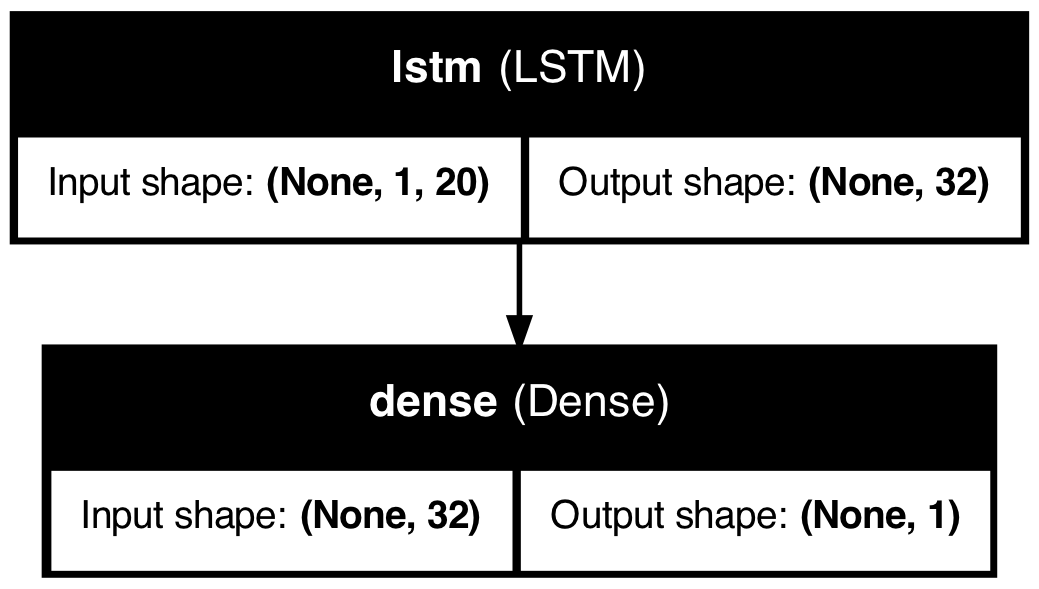

In [49]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, train_X.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])
plot_model(lstm, show_shapes=True, show_layer_names=True)

Let's fit our baseline LSTM model and see how it performs.

In [50]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - loss: 0.6914 - precision: 0.5389
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.6900 - precision: 0.5397
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.6898 - precision: 0.5399
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.6896 - precision: 0.5399
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.6895 - precision: 0.5407
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 0.6893 - precision: 0.5406
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.6892 - precision: 0.5407
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.6891 - precision: 0.5412
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.6891 - precision: 0.5405
Epoch 10/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 0.6890 - precision: 0.5410
Epoch 11/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 0.6889 - precision: 0.5419
Epoch 12

In [ ]:
y_pred = (lstm.predict(X_test) > 0.5).astype(int)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [52]:
precision = precision_score(y_test, y_pred)
print(precision)

0.5262368815592204


Our baseline LSTM could only achieve a precision score of ~0.53. Let's try tuning its hyperparameters.

### Hyperparameter Tuning

Let's tune the model's hyperparameters using Keras tuner's RandomSearch. 
1. Number of LSTM units
2. Dropout layers
3. Optimiser learning rate

The tuner will still account for the binary nature of our target due to:
1. Loss Function: We are using a binary cross entropy loss function which expects the target to be binary and the predictions to be probabilities, this ensures the model trains correctly for the binary classification task.
2. Metrics: The precision metric computes how many predictions (after applying the default threshold of 0.5) match the actual target.

In [ ]:
# def build_model(hp):
#     lstm = Sequential()
#     lstm.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), input_shape=(1, train_X.shape[1]), activation=hp.Choice('activation', ['relu', 'tanh']), return_sequences=False))
#     lstm.add(Dense(1, activation='sigmoid'))
#     lstm.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')))
#     return lstm

In [58]:
def build_model(hp):
    lstm = Sequential()
    for i in range(hp.Int("num_layers", 1, 2)):
        lstm.add(
            LSTM(units=hp.Int('units', min_value=64, max_value=512, step=32), 
                 activation='relu',
                 return_sequences=(i < hp.Int("num_layers", 1, 3) - 1),
                 recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1),
                 input_shape=(1, train_X.shape[1]) if i == 0 else None
                 ) 
            )
        # Optional: Add Dropout after LSTM layers
        if hp.Boolean(f'dropout_after_lstm_{i}'):
            lstm.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    lstm.add(Dense(1, activation='sigmoid'))
    lstm.compile(loss='binary_crossentropy', metrics=['precision'], optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')))
    return lstm

In [59]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_precision',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='./stock_market_prediction',
    project_name='stock_market'
)

In [60]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_after_lstm_0 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [61]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, random_state=42)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

Trial 10 Complete [00h 01m 03s]
val_precision: 0.5431034564971924

Best val_precision So Far: 0.5442177057266235
Total elapsed time: 00h 12m 25s
{'num_layers': 1, 'units': 192, 'recurrent_dropout': 0.2, 'dropout_after_lstm_0': True, 'learning_rate': 0.001225425591844095, 'dropout_rate_0': 0.0}


In [62]:
# Getting best model

models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 192)            │       163,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,777 (639.75 KB)

 Trainable params: 163,777 (639.75 KB)

 Non-trainable params: 0 (0.00 B)

### Retrain Model with Best Hyperparameters

In [63]:
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6908 - precision: 0.5431
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6898 - precision: 0.5415
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6896 - precision: 0.5409
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6895 - precision: 0.5416
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6894 - precision: 0.5416
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6893 - precision: 0.5417
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6892 - precision: 0.5417
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6891 - precision: 0.5424
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6890 - precision: 0.5425
Epoch 10/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6889 - precision: 0.5435
Epoch 11/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6888 - precision: 0.5444
Epoch 12/100
222/222 ━━━━━━━━━

### Final Results

In [68]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred = y_pred.ravel()
precision = precision_score(y_test, y_pred)
print("Final Model Precision Score:", precision)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
Final Model Precision Score: 0.5347334410339257


Surprisingly, the final model's precision score after hyperparameter tuning is just slightly better than our baseline LSTM model. 

In [65]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.15      0.24       339
           1       0.53      0.90      0.67       369

    accuracy                           0.54       708
   macro avg       0.55      0.52      0.45       708
weighted avg       0.55      0.54      0.46       708



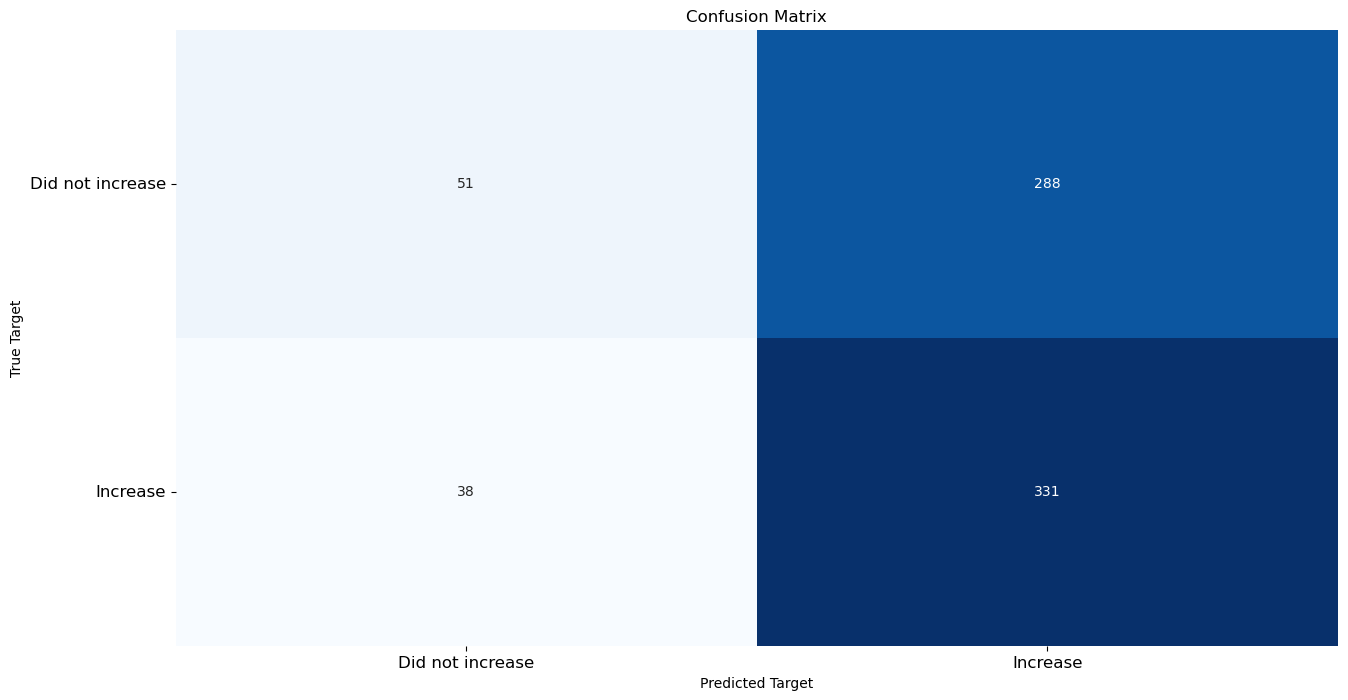

In [66]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred) 

fig = plt.figure(figsize=(15,8))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Target')
plt.ylabel('True Target')
plt.xticks(ticks=[0.5, 1.5], labels=['Did not increase', 'Increase'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['Did not increase', 'Increase'], fontsize=12, rotation=0)
plt.show()

### Conclusion and Next Steps

Even with a tuned LSTM, we are unable to achieve a precise model to predict the price movement of the S&P500. To further improve this model, we may want to add more technical indicators and perhaps include fundamental data such as companies' financials such as earnings, revenue, profit margins, dividend yield, etc. It is also worth considering to include investor sentiment analysis as the stock market is heavily influenced by news and public sentiment. Furthermore, we can also include macroeconomic data such as GDP growth rates, interest rates, etc. to provide information on the overall economic health on a given day.

All these additions may contribute to improving the performance of the model.

However, the poor performance of our model may also reflect the unpredictability and randomness of the stock market. 